# Topical Chat Data Preparation

## Developer: Yogesh Awdhut Gadade

#### Input dataset: Topical chat (Amazon Alexa AI) 

#### system configuration: On Collab

#### Which package needs to be installed
- nltk for preprocessing

In [ ]:
from pandas import DataFrame, read_json, read_csv
import gc          # Garbage collector
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

#### Versions of python and packages used in this notebook:
1. Python: 3
2. Pandas: 1.0.5 (!pip show pandas)

# Steps:

### Pre-processing of dataset:
- Unpack XML data process it and combine into DataFrame format
  - There are seperate training, validation and testing datasets
- Prepare text by applying NLP for fruther process
- creating sample ( as per professor instruction ) 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#strInputDirPath=".//input//train.json" # Set current input directory path
strInputDirPath="/content/drive/MyDrive/Stevens/Deep Learning/input/"

In [ ]:
pdInputTrainJson=read_json(strInputDirPath+"train.json") # this it what data looks like
pdInputTrainJson

,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,t_1abc9c37-387d-4013-8691-88ef8c010e58,t_1a600621-5ad4-409c-a812-bc0b2bb03aa6,t_01269680-99c3-4ab4-9df3-23901e0623c9,t_c4f84350-a9e8-4928-bde8-5193b62388e0,t_222ac48a-a52e-401a-a1c9-b2436edd8096,t_38454270-bfca-4263-8513-3fb4a05fd376,t_23942b1a-e379-41bd-826d-3e500f4f0e1a,t_f289d280-afcd-46f5-97e1-64a9e3aedc70,t_d61bd2b1-d554-406f-afb9-5a745a7a9ad1,t_16c24f06-0def-4fc5-9e47-7789d93a84d4,t_627b1554-1831-4fd3-999e-31852c1e9e3b,t_5b13346f-0d4b-4e90-a722-a9928b88f277,t_8af7f149-75d1-46f3-88ae-89d9a99620f2,t_d529bdce-9d9a-429b-9e7f-7c51fdd9d1b4,t_a767af2e-018a-4c06-beb3-1ddff22f2048,t_ffa72db2-8ba9-4469-940c-739abf2b54bb,t_3e6d55ea-4004-4beb-b8c7-0d03f13c8acb,t_74482268-77d3-4163-a15e-eeff030f9a26,t_e64823ee-4285-4296-b7c6-fa9065e0e3bb,t_a8ed3d81-bb90-4dcc-a2ff-bd28331cc6fe,t_a3697ee8-1a49-46e6-99c1-4b518edc3851,t_81182dc9-142d-4047-91e1-477d59c2a25c,t_7d121559-d936-4046-8858-7b5656135896,t_17bd17a8-78fa-4f01-993d-e026253849e9,t_c624c687-9e33-4ac3-98be-40e423571e21,t_be2b48f3-c076-4abf-a56d-f183ea8119e9,t_9acd7284-b8ad-4556-83be-1aaea0c49a2a,t_c646dc30-cf62-426d-b6c9-753f912becc4,t_e9f95fc2-29cd-464f-8f91-ae7c1ce6f8e4,t_674bb547-d741-4a75-aa14-fccedb2ff4bf,t_cc745ab5-526e-4e43-a82a-23981472b39f,t_89a2c61b-25e5-4e65-a61a-1045f3381544,t_2d13a62a-2d65-4fec-8c97-2d09fd648575,t_78655437-96b6-4fe8-89dc-814322c5246e,t_79137fd0-92f9-4896-9798-db7a48234a4d,t_3ff79e4a-45a0-46d4-a5b5-4785a1b9a555,t_10179aa3-498c-4ddb-8ac1-928202cf0546,t_5760b3e4-70f7-4857-a173-ab219a15ae0f,t_5c1b96ac-fa25-46dc-9387-d79fdb515834,...,t_c3a70766-d9d6-43c8-8f63-f7fc402e17f5,t_cb8b47ff-8fe8-4045-a24c-971cc046cae5,t_cd30e6c1-950c-4165-98a5-56e726ac887c,t_898bfdf2-d5c0-44bf-a176-647cabe7f7d2,t_b9a6ff76-f00b-4864-863e-f41b7befebf0,t_bc408a1e-918a-4909-9f8b-2704b5659769,t_3eaa4f0a-b8f9-479d-a357-49a202c0c3a8,t_80d4f4c1-e731-4508-b8ac-708989208eae,t_5aabc59f-dbfe-4eb3-82cb-42e32a0e33a4,t_b0052983-031e-43ca-9c5a-40c1874ba83d,t_c846d2ea-f587-4efb-a524-3291da0c31a8,t_17d4cc0d-1139-4f49-ac5c-25a1ca4d5c68,t_b6750a0c-649a-40e3-ad75-b79e61c2dc21,t_62fdc677-edbe-48a3-ba82-89d8b13a03f9,t_efb9e47e-bd1d-4b1b-b546-05278589dc4d,t_1a804a71-76c1-4a8e-b295-6050f6a2b997,t_b1a13891-f8c3-4f87-af65-98d3ebb34598,t_a2fe5a66-f267-477d-96a4-b1f402008448,t_57771a81-9ede-4f10-aa8d-ab5f48d2ac3b,t_dd210d2f-1ed9-4cb3-99bb-c7c8d11bc696,t_76ecff5b-c248-4729-b943-7072f23862a6,t_72b2918a-43ea-42b0-aef6-d428c47f79fd,t_36ec0b0c-0abc-43c6-bcb2-0220822052ce,t_995373a9-5123-4c98-8721-c9851ec54ea2,t_d1a1dea7-fb70-42cd-9f26-6c6519bae60b,t_20d5bd07-69a0-488c-871e-8e45bb8ad077,t_6af91bf3-01a0-43d3-ad23-28bdcff816e3,t_8a7f40e1-ad06-403d-94c3-e1bd80bbea8d,t_f16585fd-dfe3-4970-8773-0113d5b49228,t_8504091c-7b5d-43bb-9c0a-5820f770f2f1,t_529686fc-67c8-4704-9936-817817f272cf,t_c8a4d93f-bfba-4e95-a342-ac392d36d3ed,t_8d364c09-a99c-482a-a4ab-1903d093092c,t_6ff1ae46-0769-453f-8977-b62ac551e79d,t_658b2314-fa4e-4ae8-b69f-eb36f132ca58,t_56ef264f-af34-42ff-ac54-0f8d5a47e8b4,t_1a8383a5-2c8d-4687-b26e-3434b6d7fd91,t_46a82c75-d203-49c5-9d9a-2e03085d829b,t_e959a00e-5928-411f-9933-347edb6edf6b,t_884c3d36-67da-41a1-b432-6aa8601d31f7
article_url,https://www.washingtonpost.com/blogs/compost/w...,https://www.washingtonpost.com/entertainment/t...,https://www.washingtonpost.com/blogs/compost/w...,https://www.washingtonpost.com/entertainment/t...,https://www.washingtonpost.com/entertainment/t...,https://www.washingtonpost.com/blogs/compost/w...,https://www.washingtonpost.com/news/comic-riff...,https://www.washingtonpost.com/news/comic-riff...,https://www.washingtonpost.com/lifestyle/kidsp...,https://www.washingtonpost.com/lifestyle/style...,https://www.washingtonpost.com/lifestyle/style...,https://www.washingtonpost.com/lifestyle/style...,https://www.washingtonpost.com/lifestyle/style...,https://www.washingtonpost.com/national/health...,https://www.washingtonpost.com/national/health...,https://www.washingtonpost.com/national/health...,https://www.washingtonpost.com/lifestyle/kidsp...,https://www.w

In [ ]:
pdInputValJson=read_json(strInputDirPath+"valid_freq.json") # this it what data looks like
pdInputValJson

,t_a2b769a0-c082-4c26-8d8d-e2c5b8a79d93,t_5cf29dac-f886-4bc8-928d-a22dbdebe909,t_ca611053-1579-4e07-ab39-c9833b2990af,t_16325e3d-4fe8-4d6a-a25f-caefd4d03a95,t_30f5abea-bed6-4435-8e9f-a6d229026c26,t_12ad4ff3-085c-4337-8fb7-c0d6a2174c10,t_3ea7f63e-a273-4537-aac5-1dcafc853787,t_7ca0fc16-2885-4875-86b3-e0d7db9971d9,t_71da6359-2ae1-4951-963b-5229c02e61da,t_049fcf24-c2b7-4672-a4fa-822a3beb3756,t_b9fd17c8-e02d-4f03-845b-050ef98a3be7,t_f129edb1-d8e2-4624-b153-fbdb2cd8e63c,t_9b9e1b7f-3870-4b69-a918-fdc388fd44ae,t_8c2e6809-3b67-4828-a524-ef019ceb1fef,t_132b556b-bf14-44f8-9f62-3498e9938ef7,t_84deb6df-4ff2-4cbf-86b3-966833eae414,t_4ca6a5c4-dd76-4d7f-9129-d5c406bce94a,t_e278132b-f6ff-452a-84ab-f513d988c8ef,t_a3cb98ca-bef2-4922-8409-5f5753decd55,t_4b63b5c2-e228-4e3c-8a89-e5a819a77baa,t_c34c5d9d-432a-45d1-996b-d8af5b86de66,t_bb48a4ee-81b8-4442-8938-5425df42965d,t_15ffb708-486e-4265-a6a3-f567bd618514,t_9b8a8cc1-a930-4709-a22f-c70d3a247368,t_6463bc40-8c06-4aea-b399-9a685a3ccf45,t_59ff63b7-34d2-4585-8c0d-1c3c88c42f01,t_01b2127e-1c70-4918-93cb-5f23bce4ba72,t_a381b987-32dc-47f2-8196-d5a6e93ba377,t_6686f59c-e046-48ae-a3ad-afba4e367a65,t_24e90986-8199-43ce-93df-f9946a4dc3e6,t_6bbe55f0-3598-439f-b0ee-355f0c200724,t_894f6ad9-4d06-41a6-a452-4d67dad2dd49,t_f7c2f69f-b177-48c7-857a-e479753769b4,t_d9abed6c-46d6-401c-a307-2e0f699868a2,t_f5fe21c9-e19e-43e2-9d98-82058980da33,t_c1023e53-f90b-4616-a008-bf98ae7d158b,t_26fe3ef6-5e2c-448b-9e3f-89f7ffe5b5ad,t_a12194d7-8a99-45e2-9dd9-6a7abccdfdf1,t_bf9ca9bb-658f-4269-bf73-e560b0ed5805,t_c44cf045-e396-4661-bc57-9ccc5d93882c,...,t_589a2ac2-f0e3-4e8b-9666-9ec466b21f85,t_8ce98e84-8f76-4141-a155-a7d8d0eaece3,t_c18a597a-9909-4ff7-963d-bccfd666ed7f,t_a920c79d-843b-4691-bc08-8d2e4ff09385,t_2c53219d-8960-44f7-9a03-3ab96e4a7a85,t_72aa9884-edd0-428f-a032-d23e6dd70acc,t_4693cf50-105e-4ea7-88f5-f6eee4909c2c,t_f2c38e20-4113-4dee-88d5-96d3cf604fea,t_e927948c-f9b3-4bbb-a44e-28c6a37a20c2,t_3d817313-5093-446a-af8a-6f9dff560408,t_ed791963-200b-41fe-88cb-87cee1b70be0,t_bd26ab16-0f13-4fcd-94a0-b322ecc8d577,t_0de3ae79-71df-4964-98f2-b7f107477bb4,t_9c7572f9-35ad-4ee5-8158-85a8845f455f,t_9be22fd6-87d5-4aff-ad73-886efb4c5ac2,t_3d63688f-583d-4179-af38-60e956fba322,t_808b7167-97e8-4f64-9f35-3a566aa79b0a,t_7a5cb164-de53-4638-97d4-97e573f62781,t_4ccbdada-ea5f-46f8-abb9-3c94f3951d8e,t_05902d8d-b198-4d39-9389-4484b67a63bf,t_f584ab13-455e-49db-8e49-6fd78ff752ad,t_f35d4a47-3b55-4402-99c8-f9d51e8b7d4c,t_8dfb92e9-b5d4-4405-9323-211c6d52ecde,t_71a865b9-b369-45cf-a0c7-83dafa86995a,t_abd4fc13-b648-46e5-85ea-86bdf38827e6,t_81394eaf-9331-459f-a9b2-3fa23edce11e,t_595e05cd-6202-4381-98f9-5fa3da69ed2c,t_265e700d-e89d-40d6-b695-7ff3dfdf74f0,t_fbc6df23-7fcd-44b9-9f82-ae93e0b506e7,t_40177f49-1aac-45af-8a17-fbf79acb0460,t_f1c4c548-81cc-4b1b-a2ff-573273520703,t_ef661b80-92bc-4dc6-a62c-534b72ed78bb,t_a805c86d-8e3f-4add-8a39-53672e69a449,t_8ef96431-6737-4e55-a332-da6877c74535,t_1edb8c7f-1e3f-4dcd-a2b9-d25d1b8e2d43,t_d2090d67-50ca-438b-9cd0-c877bf53eecf,t_c91968e6-b091-487a-b6f4-497b68195c82,t_2bb5b0c8-5040-429f-a979-e5095c88e082,t_860f460d-43b4-46d8-b219-8ac7bc7a138d,t_ecab8282-9f5e-4e4f-ab42-d459a655ca1e
article_url,https://www.washingtonpost.com/news/football-i...,https://www.washingtonpost.com/news/football-i...,https://www.washingtonpost.com/news/football-i...,https://www.washingtonpost.com/news/wonk/wp/20...,https://www.washingtonpost.com/news/wonk/wp/20...,https://www.washingtonpost.com/news/wonk/wp/20...,https://www.washingtonpost.com/news/wonk/wp/20...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/dc-sports-...,http://www.washingtonpost.com/sports/2018/11/0...,https://www.washingtonpost.com/news/football-i...,https://www.w

In [ ]:
pdInputTestJson=read_json(strInputDirPath+"test_freq.json") # this it what data looks like
pdInputTestJson

,t_d004c097-424d-45d4-8f91-833d85c2da31,t_04eea955-7ad7-4c3c-aa0b-0fc16e89ae1d,t_f6789857-c30c-423a-bdf5-d6207dc7db9d,t_c0f787a2-1a4a-47c3-95aa-50b5567504e8,t_50e092b4-c009-4c92-8756-4b334e26db38,t_36066ee7-42fb-413c-bce1-25a6933b938a,t_a623cf24-80e2-4408-b315-714c3bfac9fb,t_3c4b17af-eb78-4ad0-a5a6-fca2c14aa4c1,t_3db0cb0e-58ac-4f80-aac9-e6ac91460545,t_50747dbe-ee88-437b-a987-e15b091f2206,t_5653dfe8-69f5-4285-a32c-cb1bd01f40b4,t_f39b54ee-1046-4f73-bd41-da933771ba1b,t_2bf05751-1489-43ec-b538-e21404300022,t_c41223cb-1b3d-4a2e-9a3f-1ad884b4a073,t_fd00ca19-25b0-4f63-a47a-0b6b1722d79a,t_6c02f06c-0cf6-4906-8ff6-eb23afbedf78,t_ca37a52a-07a5-4460-89d8-a9a933ee94ff,t_ca005e17-cb51-44c5-a475-af8fc54bd970,t_551f37f7-aea2-402b-a97e-1d1000e0d7af,t_5fb737e9-504e-49c5-bddf-e7b754522b6b,t_3394e60b-87f0-489b-a2ae-861785b9017d,t_df1cb172-90f1-48da-8d9b-818f8cb7696d,t_51d376af-dd7d-4388-a2f8-c838f92e6145,t_b31200a6-d91c-4a75-8fdc-b7af988b5aa5,t_305bd8fe-2aed-49e5-bac1-af4c9311efb9,t_e9942b54-d1b7-49b1-a2cc-b80e62260bd5,t_f11b25b0-d512-4784-a33b-bb3a34d6b63f,t_30cb4669-8dcc-48ee-8d96-0a90ee2bc662,t_6094ae1e-c74c-4dab-b6ce-ffe95284d851,t_cbefc817-cebe-4077-a010-8f304448887a,t_45f6f254-c795-4a81-adc5-a5c8fdd83599,t_ced5041a-f53e-424b-b99f-1dc9a64e0428,t_a3259110-f985-400f-a68a-23bebb5e2433,t_21b905b4-f237-45e6-9e33-812f479a17aa,t_f5297c3e-d4fc-425e-a3f9-f3a231464d1d,t_ec70278b-2709-4911-9ab6-18b9272592e1,t_fb396e70-933c-451d-99ec-82aca1d2e0e4,t_a44865eb-bcbb-43dc-8405-853cc9f1e06d,t_369cf3a0-bb67-4304-8a69-ce81a72d4667,t_58b5262d-22ab-4dc8-a0ff-96316174b53d,...,t_76f62795-f08b-4d39-aa30-33336414dca0,t_94f80a0a-e4a2-4d90-9fcf-a1e77b649b42,t_24a58edc-57f9-4096-982d-6c437509595a,t_c57007f5-69b1-4fe6-85c7-2e7670b1addf,t_ac688eea-115a-494a-b00e-5377e9ad0fd1,t_261b1e3d-d555-479c-809e-ebcd62ddb134,t_8c559c8d-4f3f-4482-a225-c0667e1b2ced,t_8c552b73-c074-4e5b-a4f7-bf8ed3a69387,t_3d36831c-5b24-4c0f-a5d3-2190ff2b2b2a,t_6abf8bbb-0d87-41d1-bbf4-47bf2743aca8,t_6af2728a-9480-4c2d-85f3-ba1006bcf410,t_c13d8421-06d8-43df-aed5-7bbc8c791efb,t_a6ced1bc-6c61-417e-9b1f-f5448f5c8e9f,t_0592dc80-e7f6-46ca-898d-9e0e7af8f513,t_5c037dce-2158-468f-b3a9-2d8bb17a3177,t_2003450a-5812-4864-a621-cff5a6062b15,t_50c8bfb1-be67-4608-9d01-f11f672a15d6,t_9b0b88ee-3026-4a76-b1e5-526ff24d7aab,t_d11f3a92-3f3a-4dae-a5a8-2206ad0d38f7,t_902a5e99-f2bb-4d09-a7e5-10dab666f965,t_dc937602-db3d-4952-97b7-12b4af955f51,t_a250b0c7-0b65-471b-a235-c43a956d6388,t_20c7c621-b989-4265-a2e5-b72a9795cf2b,t_05758702-9a62-4f64-9600-c40fc092ea71,t_ea7ec70f-3bbe-4319-9b44-6f44fa37a915,t_3e71524f-171d-4de5-9918-1af901c3dff6,t_c2aed32e-9fb9-4f7a-b6a2-066ecaf70fc0,t_51c86b54-d4d7-417c-898a-4da23fd0bf79,t_b847a771-3156-4072-a3dd-c1d4c92d1533,t_9a42d624-8484-4626-8ea6-62d7343b4616,t_28560728-a743-4bb4-8ab1-038d71fd13b5,t_d93cbf6f-2bcb-45c5-bdf6-5ad7e24751f5,t_bda7a128-9bf2-46c8-aa94-0329f8e2c2f2,t_6b20bf76-e86a-4de3-a8fb-2890cec1af57,t_e50d3a14-ac03-4f33-a777-4041a9a6b57e,t_d802e749-caf1-499b-a6da-cd7e53044033,t_3217d0cc-a755-40cb-a818-1f077abde51c,t_b0735d9b-ef1d-4c2b-9d9c-703891f01ea8,t_4fccb0c2-0e09-4c94-ba6b-7432c579b515,t_17c6e54c-24c1-4f48-bcd4-a18278380268
article_url,https://www.washingtonpost.com/sports/colleges...,https://www.washingtonpost.com/local/obituarie...,https://www.washingtonpost.com/news/dc-sports-...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/local/obituarie...,https://www.washingtonpost.com/local/obituarie...,https://www.washingtonpost.com/news/dc-sports-...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/local/obituarie...,https://www.washingtonpost.com/news/early-lead...,http://www.washingtonpost.com/sports/2018/09/2...,http://www.washingtonpost.com/sports/2018/09/2...,https://www.washingtonpost.com/news/dc-sports-...,https://www.washingtonpost.com/news/early-lead...,https://www.washingtonpost.com/news/dc-sports-...,https://www.washingtonpost.com/news/early-lead...,http://www.washingtonpost.com/sports/2018/09/2...,https://www.w

NOTE - due to computation limitation and multiple crashes while training -
- Combining train val into one
- Taking sub-sample representing distribution of origical combined one 



In [ ]:
pdInputTrainJson['t_bde29ce2-4153-4056-9eb7-f4ad710505fe']   #This is what we have per sample

article_url            https://www.washingtonpost.com/blogs/compost/w...
config                                                                 C
content                [{'message': 'Are you a fan of Google or Micro...
conversation_rating     {'agent_1': 'Excellent', 'agent_2': 'Excellent'}
Name: t_bde29ce2-4153-4056-9eb7-f4ad710505fe, dtype: object

In [ ]:
Messages=pdInputTrainJson['t_bde29ce2-4153-4056-9eb7-f4ad710505fe'].loc['content']
len(Messages)
del(Messages)

In [ ]:
from pandas import concat as PdConcat
pdInputJson=PdConcat([pdInputTrainJson, pdInputValJson], axis=1)  # Comined train-val into one

### Creating Pandas table from the XML format

In [ ]:
from pandas import concat as pdConcat

def get_message_df(lstMessages):
    pdMessages=DataFrame()
    for dictItem in lstMessages: 
        #print(dictItem)
        pdMessages=pdConcat([pdMessages, DataFrame(dictItem)], axis=0)
    return pdMessages

def map_other_details(pdMessages, strChatId, serInputJson):
    pdMessages['config']=serInputJson['config']
    pdMessages['article_url']=serInputJson['article_url']
    #print(serInputJson['conversation_rating'])
    dictAgentsRatingsToOverallChat=serInputJson['conversation_rating']
    for keys in dictAgentsRatingsToOverallChat: 
    #    print(keys, dictAgentsRatingsToOverallChat[keys])
        pdMessages[keys+'Overall']=dictAgentsRatingsToOverallChat[keys]
    pdMessages['conversation_id']=strChatId
    return pdMessages

# Pick one column at a time. 
# extact messages/chats for dataframe
# mapping other fields to the formed dataframe for messages
def get_input_data_from_xml_dump(pdDf):
    
    lstChatIds=list(pdDf.columns)
    pdChatData=DataFrame()
    i=1
    intTotalIds=len(lstChatIds)

    for strChatId in lstChatIds:

        print("Total chats: ", intTotalIds, 'Progress: {}%'.format(round((i / intTotalIds)*100)))
        pdMessages=DataFrame()

        #print("Extracting and forming datafram for chat ID:", strChatId)

        lstMessages=pdDf[strChatId].loc['content']

        #print("# of Msgs:", len(Messages))
        pdMessages=get_message_df(lstMessages)
        pdMessages=map_other_details(pdMessages, strChatId, pdDf[strChatId])  
        pdChatData=pdConcat([pdChatData, pdMessages], axis=0)
        clear_output()
        i=i+1
    lstColNames=['conversation_id', 'config', 'agent', 'message', 'agent_1Overall', 'agent_2Overall', 'sentiment', 'turn_rating', 'knowledge_source', 'article_url', ]
    return pdChatData.reset_index()[lstColNames]

### If file is not present run the code to create one and save it for later processing and model development
def get_my_combined_data(pdInputJson):
  try: 
    pdChatData=read_csv("/content/drive/MyDrive/Stevens/Deep Learning/input/ChatExpandedCombined.csv")
    print("Reading already existing expanded file.")
  except:
    pdChatData=get_input_data_from_xml_dump(pdInputJson)
    pdChatData.to_csv("/content/drive/MyDrive/Stevens/Deep Learning/input/ChatExpandedCombined.csv", index=False)
    print("file does not exists created and saved new one.")
  pdChatData=pdChatData.drop_duplicates(['agent', 'message'])
  print(f"Total number of chats (conversations) : {len(pdChatData)}")
  print(f"Total number of Agents                : {len(pdChatData.agent.unique()), list(pdChatData.agent.unique())}")
  print(f"Total number of sentiment             : {len(pdChatData.sentiment.unique()), list(pdChatData.sentiment.unique())}")
  print(f"Total number of knowledge_source      : {len(pdChatData.knowledge_source.unique()), list(pdChatData.knowledge_source.unique())}")
  return pdChatData 
%time pdChatData=get_my_combined_data(pdInputJson)

Reading already existing expanded file.
Total number of chats (conversations) : 207568
Total number of Agents                : (2, ['agent_1', 'agent_2'])
Total number of sentiment             : (8, ['Curious to dive deeper', 'Happy', 'Neutral', 'Surprised', 'Disgusted', 'Sad', 'Fearful', 'Angry'])
Total number of knowledge_source      : (8, ['FS1', 'FS2', 'FS3', 'Personal Knowledge', 'AS1', 'AS2', 'AS4', 'AS3'])
CPU times: user 1.15 s, sys: 78.3 ms, total: 1.23 s
Wall time: 1.31 s


In [ ]:
  del(pdInputJson)
  del(pdInputTrainJson)
  del(pdInputValJson)
  del(pdInputTestJson)

In [ ]:
pdChatData.head(2)

,conversation_id,config,agent,message,agent_1Overall,agent_2Overall,sentiment,turn_rating,knowledge_source,article_url
0,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,C,agent_1,Are you a fan of Google or Microsoft?,Excellent,Excellent,Curious to dive deeper,Good,FS1,https://www.washingtonpost.com/blogs/compost/w...
1,t_bde29ce2-4153-4056-9eb7-f4ad710505fe,C,agent_2,Both are excellent technology they are helpful...,Excellent,Excellent,Curious to dive deeper,Excellent,FS1,https://www.washingtonpost.com/blogs/compost/w...


### About original (raw) input dataset

This is a **Topical Chat dataset** from **Amazon**! It consists of over **8000 conversations** and over **184000 messages**!

1. Within each message, there is: A **conversation id**, which is basically which conversation the message takes place in. 
2. Each **message** is either the start of a conversation or a reply from the previous message. 
3. There is also a **sentiment**, which represents the emotion that the person who sent the message is feeling. There are **8 sentiments: Angry, Curious to Dive Deeper, Disguised, Fearful, Happy, Sad, and Surprised**.


Use of this dataset:
- This dataset can be used in machine learning to **simulate a conversation or to make a chatbot**. 
- It can also be used for **data visualization**, for example you could visualize the word usage for the different emotions.


Original github dataset:
https://github.com/alexa/Topical-Chat
Check out this research paper for this dataset: https://m.media-amazon.com/images/G/01/amazon.jobs/3079_Paper._CB1565131710_.pdf


Input in CSV format: 
PS: If you cannot download the dataset, download it from here: https://docs.google.com/spreadsheets/d/1dFdlvgmyXfN3SriVn5Byv_BNtyroICxdgrQKBzuMA1U/edit?usp=sharing






# 1. EDA
1. Total number of samples we have?
2. How many conversation id we have?
3. Avg. no. of messages across all coversations? min and max no. of messages in a conversation?
4. How many types of sentiment we have which are those
5. What is the min and max length of individual message
6. In given total # of samples find out distribution of message with types of sentiment

#### Analysis of messages
1. Length of each messages in all conversations: Avg,  Min, Max

Dropped duplicate rows: 0
Total no. of samples:                         207568          
Total no. of conversations(unique ids):       9706           
In all conversations for messages stat is:    Avg.: 21, Min: 13, Max: 51          
Total no. of types of sentiments: 8 are:
 ['Curious to dive deeper', 'Happy', 'Neutral', 'Surprised', 'Disgusted', 'Sad', 'Fearful', 'Angry']



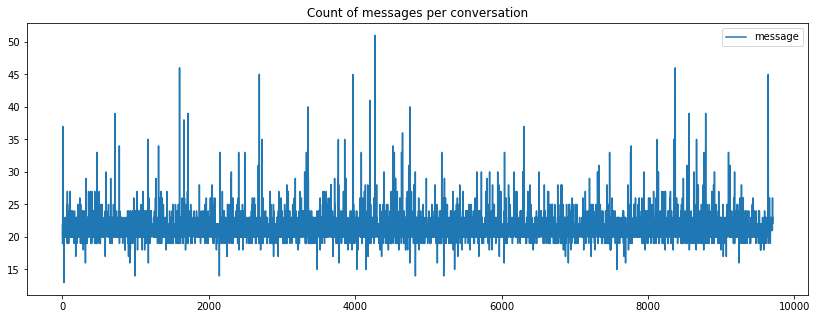

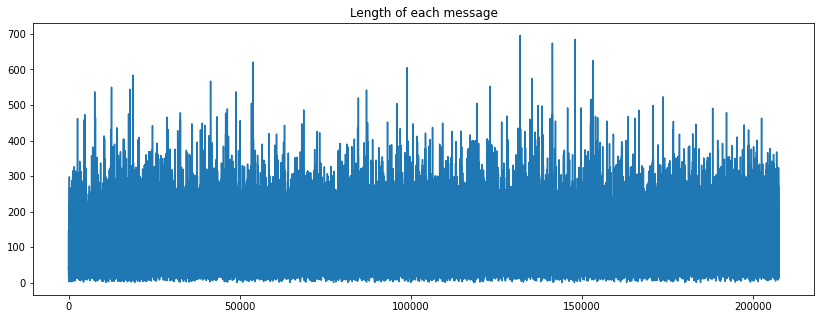

Chat length: Min:1, Mean:104.80954675094426, Max:696


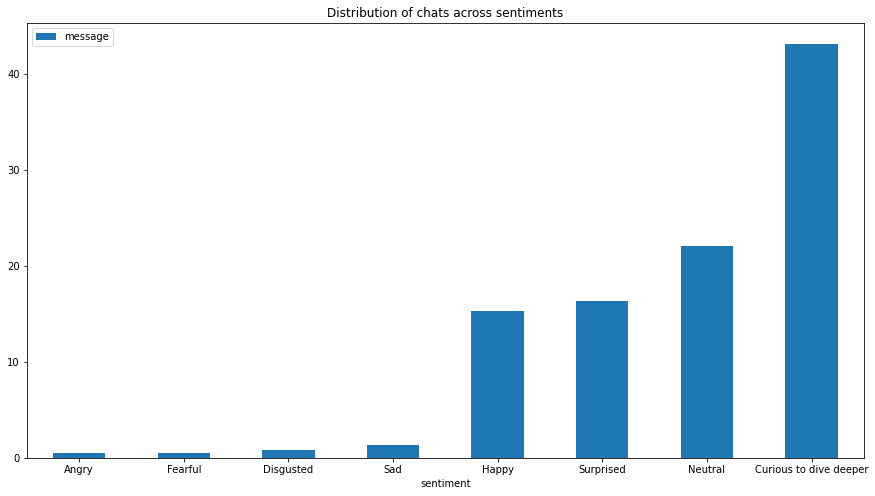

In [ ]:
def eda_get_basic_info(pdInputData):
    
    intTotalSamples=len(pdInputData)
    pdInputData=pdInputData.drop_duplicates().reset_index()[pdInputData.columns]
    print(f"Dropped duplicate rows: {intTotalSamples-len(pdInputData)}")
    intTotalSamples=len(pdInputData)
    
    
    intTotalConvIds=len(pdInputData.conversation_id.unique())
    pdMsgsCountPerConversation=pdInputData.groupby('conversation_id').count()['message']
    intMeanNoOfMsgs=round(pdMsgsCountPerConversation.mean())
    intMinNoOfMsgs=pdMsgsCountPerConversation.min()
    intMaxNoOfMsgs=pdMsgsCountPerConversation.max()
    lstTypesOfSentiments=list(pdInputData.sentiment.unique())
    print(f"Total no. of samples:                         {intTotalSamples}\
          \nTotal no. of conversations(unique ids):       {intTotalConvIds} \
          \nIn all conversations for messages stat is:    Avg.: {intMeanNoOfMsgs}, Min: {intMinNoOfMsgs}, Max: {intMaxNoOfMsgs}\
          \nTotal no. of types of sentiments: {len(lstTypesOfSentiments)} are:\n {lstTypesOfSentiments}")
    
    # ------------ Graphs --------------
    print()
    pdMsgsCountPerConversation.reset_index().plot(figsize=(14,5), title='Count of messages per conversation')
    plt.show()
    pdInputData["ChatLen"]=pdInputData.message.apply(lambda x: len(x))
    pdInputData["ChatLen"].plot(figsize=(14,5), title='Length of each message')
    #pdMsgsCountPerConversation.plot(figsize=(14,5), title='Count of messages per conversation')
    plt.show()
    intMin, intMean, intMax=pdInputData["ChatLen"].min(), pdInputData["ChatLen"].mean(), pdInputData["ChatLen"].max()
    print(f"Chat length: Min:{intMin}, Mean:{intMean}, Max:{intMax}")
    
    (100*pdInputData.groupby('sentiment').count()[['message']].sort_values(['message'])/intTotalSamples)\
    .plot(kind='bar', figsize=(15,8), rot=360, alpha=1.0, title="Distribution of chats across sentiments")
    plt.show()
    gc.collect()
    return 
eda_get_basic_info(pdChatData)

#### Observations from count of chats per conversation:
1. About 75% of total conversations having count of msgs between 19 to 22 (75% times count of msgs will lie between [19,22]) 

#### Observations from length of each chat in all conversations:
1. Minimum length is 1 and max is 696

#### Observations from sentiment distibution graph:
1. Out of total samples % messages with sentiment is not distributed eaqually.
2. More than 40% of messages are of the sentiment curious to dive deeper and others combined is less than 60%

## NOTE: Subsampling
- As per professor's instruction - because of system computation limitations creating subsample and using it for the training and testing purpose

In [ ]:
if len(pdChatData.dropna()) != len(pdChatData):
  pdChatData.dropna(inplace=True)
pdChatData=pdChatData.reset_index()[pdChatData.columns]

In [ ]:
sample_size=1000  # above 1000 it is showing error due to not enough samples in some of the classes of sentiment, 
# also system crashing at 1000 hence changing it to the 500
pdSubSample=pdChatData.groupby('sentiment').apply(lambda x: x.sample(sample_size))

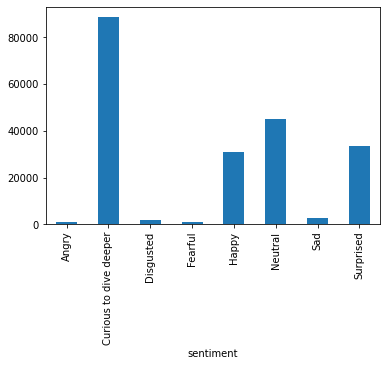

In [ ]:
pdChatData.groupby('sentiment').count()['conversation_id'].plot(kind='bar')

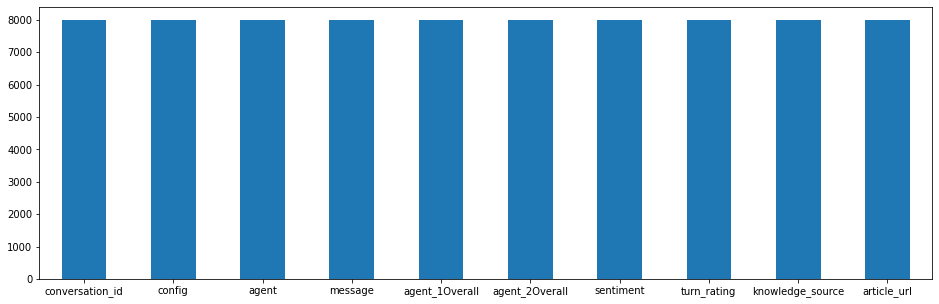

In [ ]:
pdSubSample.count().plot(kind='bar', figsize=(16, 5), rot=360)

In [ ]:
pdSubSample.reset_index(drop=True, inplace=True)

#### OBSERVATION:
- The distribution is equal across all the sentiments. But it is not same as Original dataset. Therefore will use another technique:

In [ ]:
# Using another sampling method: to get same distribution as the original dataset
intSampleSize= round(len(pdChatData)/8)    #Taking these many chats as samples for training
import numpy as np
pdSubSample=pdChatData.loc[np.random.choice(pdChatData.index, intSampleSize, replace=False)]
print("Total number of sub samples:", len(pdSubSample))
"""nrows = len(df)
total_sample_size = 1e4
df.groupby('classes').\
    apply(lambda x: x.sample(int((x.count()/nrows)*total_sample_size)))
"""
#source: https://stackoverflow.com/questions/40645524/how-can-i-sample-equally-from-a-dataframe
pdSubSample=pdSubSample.reset_index()[pdSubSample.columns]

Total number of sub samples: 25633


In [ ]:
pdSubSample.value_counts('sentiment')

sentiment
Curious to dive deeper    11070
Neutral                    5624
Surprised                  4224
Happy                      3928
Sad                         307
Disgusted                   233
Angry                       124
Fearful                     123
dtype: int64

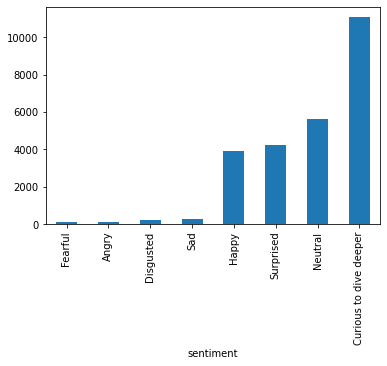

In [ ]:
pdSubSample.groupby('sentiment').count().sort_values('conversation_id')['conversation_id'].plot(kind='bar')

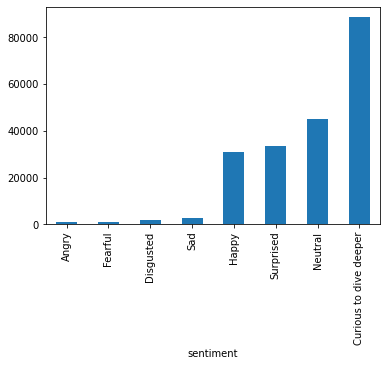

In [ ]:
pdChatData.groupby('sentiment').count().sort_values('conversation_id')['conversation_id'].plot(kind='bar')

### OBSERVATION:
- In the subsample we got from the above step giving us the same distribution as the original dataset has. Hence going to use this for further training and tesing. 

In [ ]:
# if not present download following
import nltk

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# Preprocess the dataset:
from keras.preprocessing.text import text_to_word_sequence
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import word_tokenize, pos_tag


stop_words = set(stopwords.words('english'))
stemmer= PorterStemmer()
lemmatizer = WordNetLemmatizer()

def preprocessDataset(train_text):
    global stop_words, stemmer, lemmatizer
    #gc.collect()
    #word tokenization using text-to-word-sequence
    train_text= str(train_text)
    tokenized_train_set = text_to_word_sequence(train_text,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',\
                                                lower=True,split=" ")
    print("tokenized_train_set:", tokenized_train_set)
    #stop word removal
    stopwordremove = [i for i in tokenized_train_set if not i in stop_words]
        
     
    #join words into sentence
    stopwordremove_text = ' '.join(stopwordremove)
        
        
    #remove numbers
    numberremove_text = ''.join(c for c in stopwordremove_text if not c.isdigit())
       
    print("stop words and numbers removed:", numberremove_text)    
    #--Stemming--
    print("Stemming")
    #stemmer= PorterStemmer()

    stem_input=word_tokenize(numberremove_text)
    stem_text=' '.join([stemmer.stem(word) for word in stem_input])
        
    print("stem_text:", stem_text)      
    #lemmatizer = WordNetLemmatizer()
    print("Lemitizing")
    def get_wordnet_pos(word):
        """Map POS tag to first character lemmatize() accepts"""
        tag = pos_tag([word])[0][1][0].upper()
        tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

        return tag_dict.get(tag, wordnet.NOUN)
    
    lem_input = word_tokenize(stem_text)
    lem_text= ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in lem_input])
    print("lem_text:", lem_text)
    #Stemming and lemmatization are methods used by search engines and chatbots to analyze the meaning behind a word. 
    #Stemming uses the stem of the word, while lemmatization uses the context in which the word is being used. 
    #We'll later go into more detailed explanations and examples.  
    
    #del(train_text)
    #del(lem_input)
    #del(stem_text)
    #del(tokenized_train_set)
    #gc.collect()
    
    clear_output()
    return lem_text

pdTemp=pdSubSample[['message']]
%time pdSubSample['LemmatizedText'] = pdTemp['message'].apply(preprocessDataset)
pdSubSample.head(2)

CPU times: user 4min 5s, sys: 1min 1s, total: 5min 7s
Wall time: 4min 21s


,conversation_id,config,agent,message,agent_1Overall,agent_2Overall,sentiment,turn_rating,knowledge_source,article_url,LemmatizedText
0,t_86627de2-fe27-42f1-9250-85054ba5353b,B,agent_1,Have you seen Ethiopias version of Top Chef?,Good,Good,Curious to dive deeper,Good,FS2,https://www.washingtonpost.com/news/inspired-l...,see ethiopia version top chef
1,t_f3a6d5fb-7f18-41e9-9ab1-5599d265812f,C,agent_2,It has been a pleasure talking to you too. En...,Good,Passable,Happy,Good,Personal Knowledge,https://www.washingtonpost.com/local/human-rem...,pleasur talk enjoy rap music internet


In [ ]:
pdSubSample.head(2)[['conversation_id','message','LemmatizedText']]

,conversation_id,message,LemmatizedText
0,t_86627de2-fe27-42f1-9250-85054ba5353b,Have you seen Ethiopias version of Top Chef?,see ethiopia version top chef
1,t_f3a6d5fb-7f18-41e9-9ab1-5599d265812f,It has been a pleasure talking to you too. En...,pleasur talk enjoy rap music internet


In [ ]:
pdSubSample.to_csv("/content/drive/MyDrive/Stevens/Deep Learning/input/sampling.csv", index=False) # used in the sentiment analysis using LSTM NN, BERT implementations

In [ ]:
print('Total number of rows we have: ', len(pdSubSample))

Total number of rows we have:  25633


# Creating QA format between Agent 1 and Agent 2 for the Transformer training

In [ ]:
pdQA=DataFrame()
# For each conversation pair up 
def pairup_agent1_agent2(pdChatData):
  global pdQA
  lstConversationId=list(pdChatData.conversation_id.unique())
  intLen=len(lstConversationId)
  i=1
  for conversation_id in lstConversationId:
    print(f"{intLen}, {i}, {round(100*i/intLen)}%")
    pdAConversation=pdChatData[ pdChatData['conversation_id'] == conversation_id]
    pdAgent1=pdAConversation [ pdAConversation.agent == 'agent_1' ].rename(columns={"message":"Agent1", "sentiment": "Agent1_sentiment"})
    pdAgent2=pdAConversation [ pdAConversation.agent == 'agent_2' ].rename(columns={"message":"Agent2", "sentiment": "Agent2_sentiment"})
    pdConversations=pdConcat([pdAgent1.reset_index()[['Agent1', 'Agent1_sentiment']], pdAgent2.reset_index()[['Agent2', 'Agent2_sentiment']]], axis=1)
    # If one agent ends the communication it can happen there no reply from other agent for such entries imputing following string
    pdConversations[['Agent1', 'Agent2']].fillna("Nice to chat with you. Thank you.", inplace=True)   # sentimen class will be same
    #print(pdConversations)
    #pdConversations[['Agent1_sentiment', 'Agent2_sentiment']].fillna("No Response", inplace=True)
    pdConversations['conversation_id']=''
    pdConversations['conversation_id']=conversation_id
    if(len(pdQA) == 0): pdQA=pdConversations
    else: pdQA=pdConcat([pdQA, pdConversations], axis=0)
    clear_output()
    i=i+1
%time pairup_agent1_agent2(pdChatData)

CPU times: user 4min 32s, sys: 19.8 s, total: 4min 51s
Wall time: 4min 32s


In [ ]:
pdQA[pdQA.conversation_id =='t_17c6e54c-24c1-4f48-bcd4-a18278380268']

,Agent1,Agent1_sentiment,Agent2,Agent2_sentiment,conversation_id
0,Do you think what Nick Saban did to the ESPN ...,Surprised,I was wondering the same thing. I think person...,Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
1,"Exactly. you can have some sympathy, without t...",Neutral,Yes definitely but it's just general wisdom to...,Neutral,t_17c6e54c-24c1-4f48-bcd4-a18278380268
2,Do you think Saban will call the reporter and ...,Neutral,"Actually I heard that he already did, or at le...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
3,Didn't know. To be honest I am surprised he did.,Neutral,"Oh really, why is that? I'm sure he realized t...",Surprised,t_17c6e54c-24c1-4f48-bcd4-a18278380268
4,He is definitely not the kind of people who ap...,Surprised,"Oh, hmm maybe that tweet by James Miller was i...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
5,I am pretty good at telling how people are by ...,Surprised,"Oh I didn't know that, when did he do it before?",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
6,Almost most of the time he is being interview....,Surprised,"Oh yes, that's true but at least that's not as...",Neutral,t_17c6e54c-24c1-4f48-bcd4-a18278380268
7,Really?! What did he did to her? Haven't heard...,Neutral,"He snapped at her, and gave an abrasive respon...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
8,Wow!! That´s way too much. Don´t you think he ...,Neutral,"I'm not sure, he did apologize at least but I ...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
9,"You are kind of right, but definitely somethin...",Neutral,"I guess, maybe I don't think it's the big of d...",Neutral,t_17c6e54c-24c1-4f48-bcd4-a18278380268


In [ ]:
pdQA[['Agent1', 'Agent2']]

,Agent1,Agent2
0,Are you a fan of Google or Microsoft?,Both are excellent technology they are helpful...
1,"I'm not a huge fan of Google, but I use it a ...",Google provides online related services and pr...
2,"Yeah, their services are good. I'm just not a ...",Google is leading the alphabet subsidiary and ...
3,Did you know Google had hundreds of live goats...,"It is very interesting. Google provide ""Chrome..."
4,I like Google Chrome. Do you use it as well fo...,Yes.Google is the biggest search engine and Go...
...,...,...
6,Almost most of the time he is being interview....,"Oh yes, that's true but at least that's not as..."
7,Really?! What did he did to her? Haven't heard...,"He snapped at her, and gave an abrasive respon..."
8,Wow!! That´s way too much. Don´t you think he ...,"I'm not sure, he did apologize at least but I ..."
9,"You are kind of right, but definitely somethin...","I guess, maybe I don't think it's the big of d..."


In [ ]:
print("We have total number of chats with use: ", len(pdQA))

We have total number of chats with use:  105625


In [ ]:
# Saving the Question and answers:
pdQA.dropna().to_csv("/content/drive/MyDrive/Stevens/Deep Learning/input/Agent1_Agnet2_QA_format_sequential.csv", index=False)

In [ ]:
from pandas import read_csv 
read_csv("/content/drive/MyDrive/Stevens/Deep Learning/input/Agent1_Agnet2_QA_format_sequential.csv")

,Agent1,Agent1_sentiment,Agent2,Agent2_sentiment,conversation_id
0,Are you a fan of Google or Microsoft?,Curious to dive deeper,Both are excellent technology they are helpful...,Curious to dive deeper,t_bde29ce2-4153-4056-9eb7-f4ad710505fe
1,"I'm not a huge fan of Google, but I use it a ...",Curious to dive deeper,Google provides online related services and pr...,Curious to dive deeper,t_bde29ce2-4153-4056-9eb7-f4ad710505fe
2,"Yeah, their services are good. I'm just not a ...",Curious to dive deeper,Google is leading the alphabet subsidiary and ...,Curious to dive deeper,t_bde29ce2-4153-4056-9eb7-f4ad710505fe
3,Did you know Google had hundreds of live goats...,Curious to dive deeper,"It is very interesting. Google provide ""Chrome...",Curious to dive deeper,t_bde29ce2-4153-4056-9eb7-f4ad710505fe
4,I like Google Chrome. Do you use it as well fo...,Curious to dive deeper,Yes.Google is the biggest search engine and Go...,Curious to dive deeper,t_bde29ce2-4153-4056-9eb7-f4ad710505fe
...,...,...,...,...,...
99431,Almost most of the time he is being interview....,Surprised,"Oh yes, that's true but at least that's not as...",Neutral,t_17c6e54c-24c1-4f48-bcd4-a18278380268
99432,Really?! What did he did to her? Haven't heard...,Neutral,"He snapped at her, and gave an abrasive respon...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
99433,Wow!! That´s way too much. Don´t you think he ...,Neutral,"I'm not sure, he did apologize at least but I ...",Curious to dive deeper,t_17c6e54c-24c1-4f48-bcd4-a18278380268
99434,"You are kind of right, but definitely somethin...",Neutral,"I guess, maybe I don't think it's the big of d...",Neutral,t_17c6e54c-24c1-4f48-bcd4-a18278380268


In [ ]:
print('Sample question: {}'.format(questions[20]))
print('Sample answer: {}'.format(answers[20]))